In [1]:
from transformers import SegformerFeatureExtractor
import PIL.Image

#一个把图像转换为数据的工具类
feature_extractor = SegformerFeatureExtractor()

#模拟一批数据
pixel_values = [
    PIL.Image.new('RGB', (200, 100), 'blue'),
    PIL.Image.new('RGB', (200, 100), 'red')
]

value = [
    PIL.Image.new('L', (200, 100), 150),
    PIL.Image.new('L', (200, 100), 200)
]

#试算
out = feature_extractor(pixel_values, value)
print('keys=', out.keys())
print('type=', type(out['pixel_values']), type(out['labels']))
print('len=', len(out['pixel_values']), len(out['labels']))
print('type0=', type(out['pixel_values'][0]), type(out['labels'][0]))
print('shape0=', out['pixel_values'][0].shape, out['labels'][0].shape)

feature_extractor

keys= dict_keys(['pixel_values', 'labels'])
type= <class 'list'> <class 'list'>
len= 2 2
type0= <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape0= (3, 512, 512) (512, 512)


SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 512
}

ColorJitter(brightness=[0.75, 1.25], contrast=[0.75, 1.25], saturation=[0.75, 1.25], hue=[-0.1, 0.1])


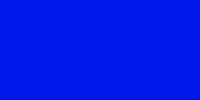

In [2]:
from torchvision.transforms import ColorJitter

#能对图像进行亮度，对比度，饱和度，色相变换的工具类。其实就是数据增强
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

print(jitter)

jitter(PIL.Image.new('RGB', (200, 100), 'blue'))

In [3]:
from datasets import load_dataset, load_from_disk

#一个道路分类数据集
#dataset = load_dataset(path='segments/sidewalk-semantic')
dataset = load_from_disk('datas/segments/sidewalk-semantic')


#把图片数据全部转换为数字
def transforms(data):
    pixel_values = data['pixel_values']
    label = data['label']

    #应用数据增强
    pixel_values = [jitter(i) for i in pixel_values]

    #编码图片成数字
    return feature_extractor(pixel_values, label)


#切分训练集和测试集
dataset = dataset.shuffle(seed=1)['train'].train_test_split(test_size=0.1)

dataset['train'] = dataset['train'].with_transform(transforms)

print(dataset['train'][0])

dataset

Loading cached shuffled indices for dataset at datas/segments/sidewalk-semantic/train/cache-867706e2b6fd7502.arrow


{'pixel_values': array([[[ 0.63918144,  0.63918144,  0.6563062 , ..., -0.2170563 ,
         -0.2170563 , -0.2855553 ],
        [ 0.63918144,  0.63918144,  0.6563062 , ..., -0.2170563 ,
         -0.19993155, -0.2855553 ],
        [ 0.63918144,  0.6563062 ,  0.673431  , ..., -0.2170563 ,
         -0.19993155, -0.30268008],
        ...,
        [ 0.02269024,  0.27956167,  0.39943492, ..., -0.02868402,
         -0.08005828, -0.04580877],
        [ 0.10831413,  0.2966864 ,  0.33093593, ...,  0.17681314,
          0.2281874 ,  0.14256364],
        [ 0.07406463,  0.2281874 ,  0.1939379 , ...,  0.2624369 ,
         -0.01155927,  0.07406463]],

       [[ 0.81792724,  0.81792724,  0.83543426, ..., -0.17997196,
         -0.17997196, -0.24999997],
        [ 0.81792724,  0.81792724,  0.81792724, ..., -0.17997196,
         -0.16246496, -0.24999997],
        [ 0.81792724,  0.81792724,  0.83543426, ..., -0.17997196,
         -0.16246496, -0.26750696],
        ...,
        [ 0.13515405,  0.3977592 ,  0

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 900
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 100
    })
})

In [4]:
import torch


def collate_fn(data):
    pixel_values = [i['pixel_values'] for i in data]
    labels = [i['labels'] for i in data]

    pixel_values = torch.FloatTensor(pixel_values)
    labels = torch.LongTensor(labels)

    return {'pixel_values': pixel_values, 'labels': labels}


loader = torch.utils.data.DataLoader(
    dataset=dataset['train'],
    batch_size=4,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

for i, data in enumerate(loader):
    break

len(loader), data['pixel_values'].shape, data['labels'].shape

/root/anaconda3/envs/cpu/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)
  


(225, torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))

In [5]:
#因为模型的计算输出是原尺寸除以4，所以需要把结果扩张成原来的大小便于计算正确率什么的
torch.nn.functional.interpolate(torch.randn(4, 35, 128, 128),
                                size=(512, 512),
                                mode='bilinear',
                                align_corners=False).shape

torch.Size([4, 35, 512, 512])

In [6]:
from transformers import SegformerForSemanticSegmentation, SegformerModel

#加载模型
#一共35中道路类别，怎么来的不重要
#model = SegformerForSemanticSegmentation.from_pretrained('nvidia/mit-b0',num_labels=35)


#定义下游任务模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained = SegformerModel.from_pretrained('nvidia/mit-b0')

        self.linears = torch.nn.ModuleList([
            torch.nn.Linear(32, 256),
            torch.nn.Linear(64, 256),
            torch.nn.Linear(160, 256),
            torch.nn.Linear(256, 256)
        ])

        self.classifier = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1024,
                            out_channels=256,
                            kernel_size=1,
                            bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Conv2d(256, 35, kernel_size=1),
        )
        
        #加载预训练模型的参数
        parameters = SegformerForSemanticSegmentation.from_pretrained('nvidia/mit-b0',num_labels=35)
        for i in range(4):
            self.linears[i].load_state_dict(parameters.decode_head.linear_c[i].proj.state_dict())
            
        self.classifier[0].load_state_dict(parameters.decode_head.linear_fuse.state_dict())
        self.classifier[1].load_state_dict(parameters.decode_head.batch_norm.state_dict())
        self.classifier[4].load_state_dict(parameters.decode_head.classifier.state_dict())

        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    def forward(self, pixel_values, labels):
        #pixel_values -> [4, 3, 512, 512]
        #labels -> [4, 512, 512]

        #首先通过预训练模型抽中间特征
        #[4, 32, 128, 128]
        #[4, 64, 64, 64]
        #[4, 160, 32, 32]
        #[4, 256, 16, 16]
        features = self.pretrained(pixel_values=pixel_values,
                                   output_hidden_states=True)
        features = features.hidden_states

        #打平
        #[4, 32, 16384]
        #[4, 64, 4096]
        #[4, 160, 1024]
        #[4, 256, 256]
        features = [i.flatten(2) for i in features]

        #转置，把通道放到最后一个维度
        #[4, 16384, 32]
        #[4, 4096, 64]
        #[4, 1024, 160]
        #[4, 256, 256]
        features = [i.transpose(1, 2) for i in features]

        #线性计算
        #[4, 16384, 256]
        #[4, 4096, 256]
        #[4, 1024, 256]
        #[4, 256, 256]
        features = [l(f) for f, l in zip(features, self.linears)]

        #转置回来，把通道放中间
        #[4, 256, 16384]
        #[4, 256, 4096]
        #[4, 256, 1024]
        #[4, 256, 256]
        features = [i.permute(0, 2, 1) for i in features]

        #变形成二维的图片
        #[4, 256, 128, 128]
        #[4, 256, 64, 64]
        #[4, 256, 32, 32]
        #[4, 256, 16, 16]
        features = [
            f.reshape(pixel_values.shape[0], -1, s, s)
            for f, s in zip(features, [128, 64, 32, 16])
        ]

        #拓展到统一的尺寸
        #[4, 256, 128, 128]
        #[4, 256, 128, 128]
        #[4, 256, 128, 128]
        #[4, 256, 128, 128]
        features = [
            torch.nn.functional.interpolate(i,
                                            size=(128, 128),
                                            mode='bilinear',
                                            align_corners=False)
            for i in features
        ]

        #逆序，维度不变
        features = features[::-1]

        #在通道维度合并成一个张量
        #[4, 1024, 128, 128]
        features = torch.cat(features, dim=1)

        #跑分类网络，其中包括了1024->256->35两步，使用cnn网络实现
        #[4, 35, 128, 128]
        features = self.classifier(features)

        #为了计算loss，要把计算结果放大到和labels一致
        #[4, 35, 128, 128] -> [4, 35, 512, 512]
        #计算交叉熵loss
        loss = self.criterion(
            torch.nn.functional.interpolate(features,
                                            size=(512, 512),
                                            mode='bilinear',
                                            align_corners=False), labels)

        return {'loss': loss, 'logits': features}


model = Model()

#统计参数量
print(sum(i.numel() for i in model.parameters()) / 10000)

out = model(**data)

out['loss'], out['logits'].shape

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

372.3139


(tensor(3.5569, grad_fn=<NllLoss2DBackward0>), torch.Size([4, 35, 128, 128]))

In [7]:
from datasets import load_metric

#加载评价指标
metric = load_metric('mean_iou')

#试算
metric.compute(
    predictions=torch.ones(4, 10, 10),
    references=torch.ones(4, 10, 10),
    #一共35中道路类别，怎么来的不重要
    num_labels=35,
    #忽略背景类0
    ignore_index=0,
    reduce_labels=False)

Using the latest cached version of the module from /root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342 (last modified on Sat Jul  2 18:02:07 2022) since it couldn't be found locally at mean_iou, or remotely on the Hugging Face Hub.
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


{'mean_iou': 1.0,
 'mean_accuracy': 1.0,
 'overall_accuracy': 1.0,
 'per_category_iou': array([nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'per_category_accuracy': array([nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan])}

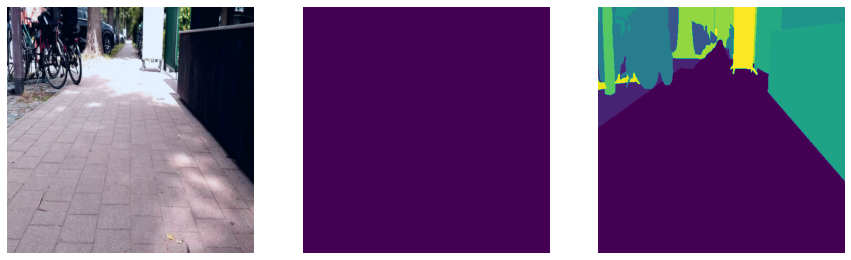

In [8]:
from matplotlib import pyplot as plt


def show(image, out, label):
    plt.figure(figsize=(15, 5))

    image = image.clone()
    image = image.permute(1, 2, 0)
    image = image - image.min().item()
    image = image / image.max().item()
    image = image * 255
    image = PIL.Image.fromarray(image.numpy().astype('uint8'), mode='RGB')
    image = image.resize((512, 512))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')

    out = PIL.Image.fromarray(out.numpy().astype('uint8'))
    plt.subplot(1, 3, 2)
    plt.imshow(out)
    plt.axis('off')

    label = PIL.Image.fromarray(label.numpy().astype('uint8'))
    plt.subplot(1, 3, 3)
    plt.imshow(label)
    plt.axis('off')

    plt.show()


show(data['pixel_values'][0], torch.ones(512, 512), data['labels'][0])

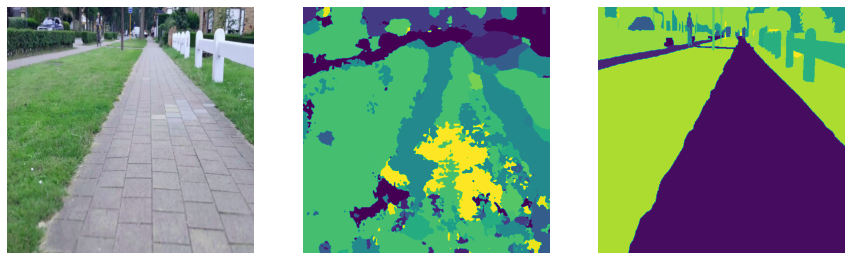

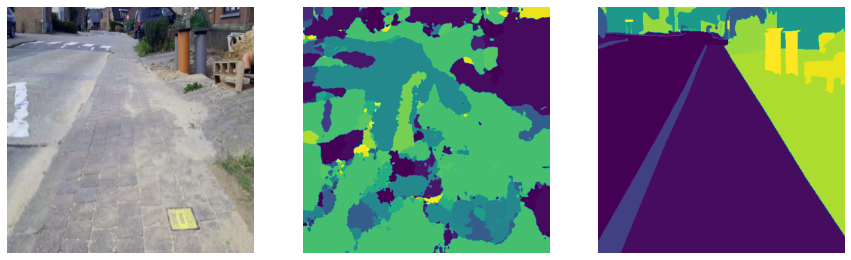

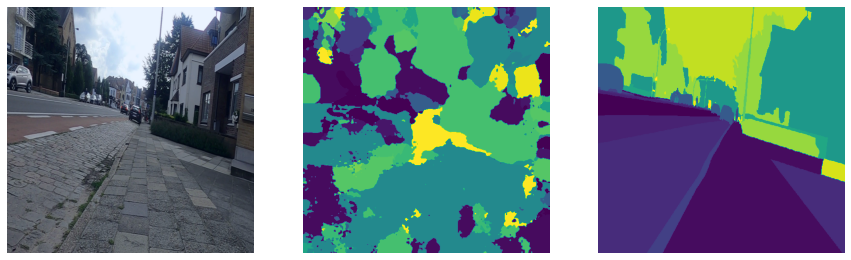

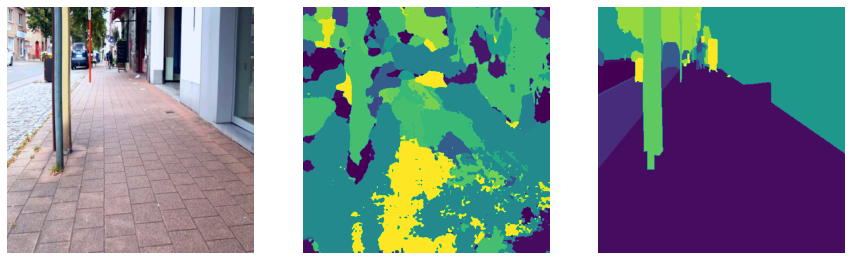

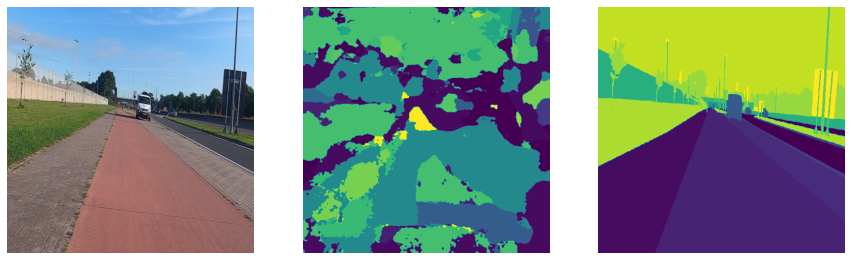

{'mean_iou': 0.004544364567422314, 'mean_accuracy': 0.03867088329560427, 'overall_accuracy': 0.021572502736092656}
0.02157250067877789


/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [9]:
def test():
    model.eval()

    dataset['test'] = dataset['test'].shuffle()

    loader_test = torch.utils.data.DataLoader(
        dataset=dataset['test'].with_transform(transforms),
        batch_size=8,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=True,
    )

    labels = []
    outs = []
    correct = 0
    #初始化为1，防止除0
    total = 1
    for i, data in enumerate(loader_test):
        with torch.no_grad():
            out = model(**data)

        #运算结果扩张4倍
        out = torch.nn.functional.interpolate(out['logits'],
                                              size=(512, 512),
                                              mode='bilinear',
                                              align_corners=False)

        out = out.argmax(dim=1)
        outs.append(out)

        label = data['labels']
        labels.append(label)

        #统计正确率时排除label中的0
        select = label != 0
        correct += (label[select] == out[select]).sum().item()
        total += len(label[select])

        if i % 1 == 0:
            show(data['pixel_values'][0], out[0], label[0])

        if i == 4:
            break

    #计算评价指标
    metric_out = metric.compute(predictions=torch.cat(outs, dim=0),
                                references=torch.cat(labels, dim=0),
                                num_labels=35,
                                ignore_index=0)

    #删除这两个结果，不想看
    metric_out.pop('per_category_iou')
    metric_out.pop('per_category_accuracy')

    print(metric_out)
    print(correct / total)


test()

In [10]:
from transformers import AdamW
from transformers.optimization import get_scheduler


def train():
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_scheduler(name='linear',
                              num_warmup_steps=0,
                              num_training_steps=len(loader) * 3,
                              optimizer=optimizer)

    model.train()
    for i, data in enumerate(loader):
        out = model(**data)
        loss = out['loss']

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()
        model.zero_grad()

        if i % 10 == 0:
            #运算结果扩张4倍
            out = torch.nn.functional.interpolate(
                out['logits'],
                size=(512, 512),
                mode='bilinear',
                align_corners=False).argmax(dim=1)

            label = data['labels']

            #计算评价指标
            metric_out = metric.compute(predictions=out,
                                        references=label,
                                        num_labels=35,
                                        ignore_index=0)

            #删除这两个结果，不想看
            metric_out.pop('per_category_iou')
            metric_out.pop('per_category_accuracy')

            #统计正确率时排除label中的0
            select = label != 0
            label = label[select]
            out = out[select]
            #防止除0
            accuracy = (label == out).sum().item() / (len(label) + 1)
            lr = optimizer.state_dict()['param_groups'][0]['lr']
            print(i, loss.item(), lr, metric_out, accuracy)

        torch.save(model, 'models/9.抠图.model')


train()

/root/anaconda3/envs/cpu/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


0 3.5700504779815674 4.9925925925925926e-05 {'mean_iou': 0.002001611984429413, 'mean_accuracy': 0.008581811715043764, 'overall_accuracy': 0.009996414184570312} 0.00999640465125594


/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


10 3.151561737060547 4.918518518518519e-05 {'mean_iou': 0.06859740965229229, 'mean_accuracy': 0.14224015106419413, 'overall_accuracy': 0.5127334594726562} 0.5127329704923911
20 2.873392105102539 4.844444444444445e-05 {'mean_iou': 0.0788982877524727, 'mean_accuracy': 0.19312249573827742, 'overall_accuracy': 0.5785760879516602} 0.5785755361790312
30 2.8348758220672607 4.770370370370371e-05 {'mean_iou': 0.08408599853674109, 'mean_accuracy': 0.20303103016674784, 'overall_accuracy': 0.49300098419189453} 0.4930005140299663
40 2.393402576446533 4.6962962962962966e-05 {'mean_iou': 0.1126560091507178, 'mean_accuracy': 0.23763828185808994, 'overall_accuracy': 0.674382209777832} 0.6743815666374525
50 2.4596214294433594 4.6222222222222224e-05 {'mean_iou': 0.08841059600749897, 'mean_accuracy': 0.20344496489832142, 'overall_accuracy': 0.5698947906494141} 0.5698942471559075
60 2.19781231880188 4.548148148148149e-05 {'mean_iou': 0.1265828856573883, 'mean_accuracy': 0.23526268442738776, 'overall_accura

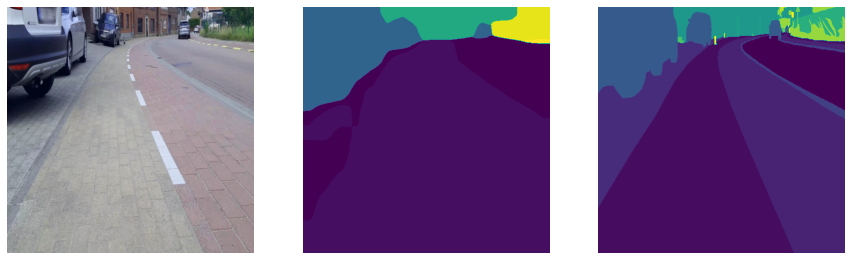

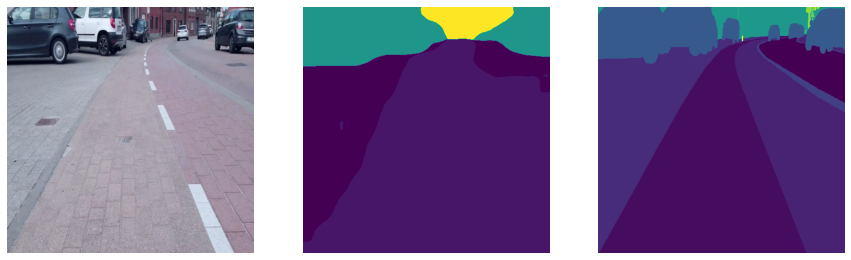

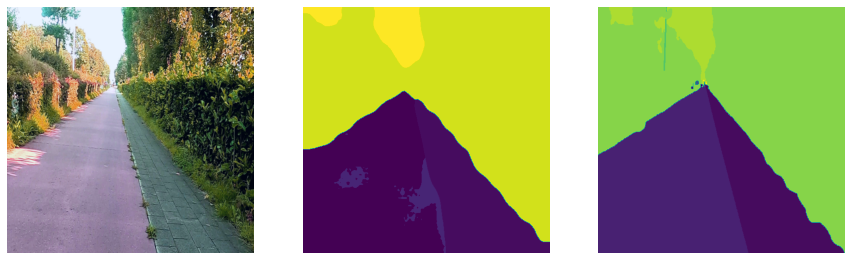

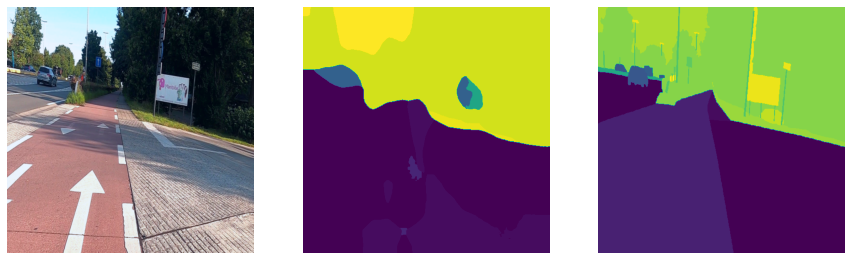

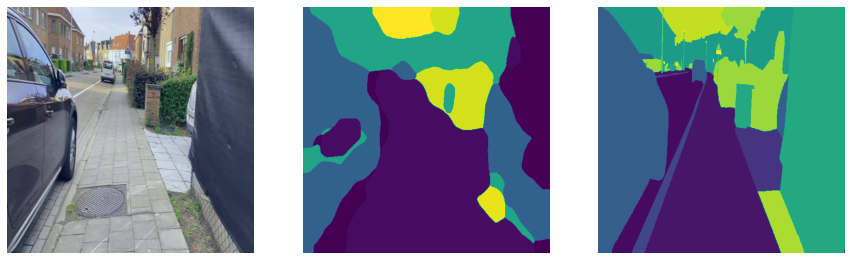

{'mean_iou': 0.15280237091916576, 'mean_accuracy': 0.20683474931136797, 'overall_accuracy': 0.6982137989978369}
0.6982137324107197


In [11]:
model = torch.load('models/9.抠图.model')
test()